In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('./archive/2023_GradesVsPeriodAttendance_01.csv')

print(df.school_name.unique())

['West High School' 'North High School' 'South High School'
 'Hope High School' 'Sunny High School' 'Small High School'
 'East High School']


1. Vaikuttaako poissaolojen määrä oppilaan saamiin arvosanoihin?
- Kysymys: Onko oppilailla, joilla on enemmän poissaoloja, keskimäärin huonommat arvosanat?
- Analyysi: Tarkastelkaa poissaolojen määrää eri oppitunneilla ja verratkaa sitä oppilaan saamiin arvosanoihin.

In [33]:
# Tähän koodisoluun voit kirjoittaa koodia, joka vastaa yllä esitettyyn kysymykseen.

2. Mitkä oppitunnit ovat herkimmin altistettuja poissaoloille?
-  Kysymys: Onko joillakin oppitunneilla (esim. ensimmäinen tai kuudes tunti) enemmän poissaoloja kuin muilla?
Vastaus:
Havaitsimme selviä eroja poissaolomäärissä eri jaksojen ja luokka-asteiden välillä.
Ensimmäinen oppitunti on kaikilla luokka-asteilla poissaoloille alttiimpi verrattuna muihin tunteihin. Mitä vanhempiin opiskelijoihin mennään, sitä enemmän poissaoloja kertyy aamun ensimmäisille tunneille. Kuudennen tunnin poissaolot puolestaan laskevat erityisesti vanhempien opiskelijoiden kohdalla, mikä viittaa mahdollisiin aikataulullisiin muutoksiin tai opiskelijoiden sitoutumiseen loppupäivän tunneilla.

Tämä tieto voi auttaa kouluja kohdentamaan toimenpiteitä juuri aamun ensimmäisiin tunteihin, jotta poissaoloja voitaisiin vähentää erityisesti ylemmillä luokka-asteilla.


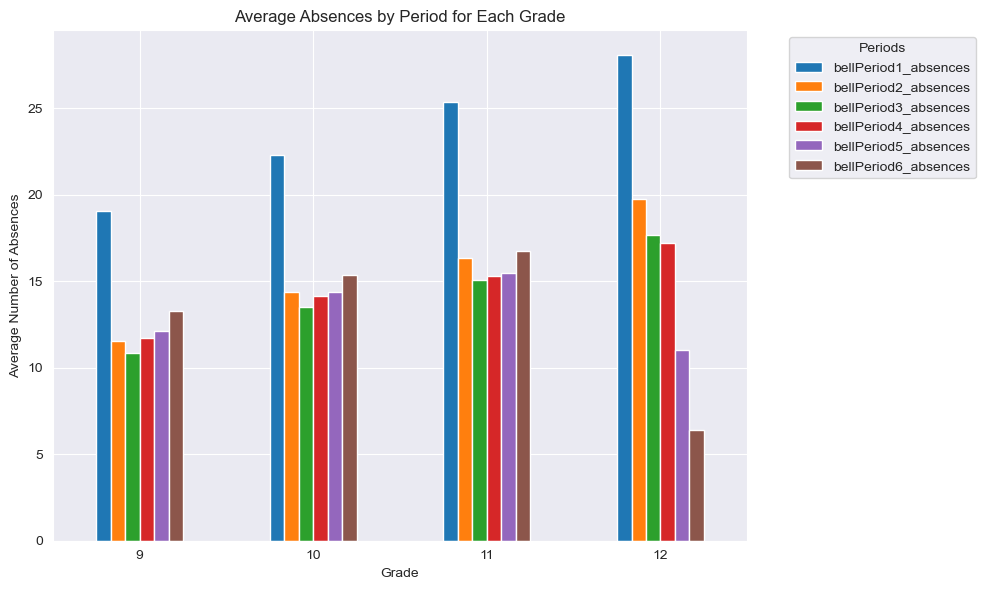

In [34]:
# Calculate average absences for each period, grouped by grade
average_absences_by_grade = df.groupby('grade')[
    ['bellPeriod1_absences', 'bellPeriod2_absences', 'bellPeriod3_absences',
     'bellPeriod4_absences', 'bellPeriod5_absences', 'bellPeriod6_absences']
].mean()

# Display the average absences per period for each grade
average_absences_by_grade

# Plot the results (Optional: if you'd like a visual representation)
import matplotlib.pyplot as plt

# Set up the plot
average_absences_by_grade.plot(kind='bar', figsize=(10,6))
plt.title('Average Absences by Period for Each Grade')
plt.ylabel('Average Number of Absences')
plt.xlabel('Grade')
plt.xticks(rotation=0)
plt.legend(title='Periods', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


3. Onko tietyn vuoden opiskelijoilla (esim. 9., 10., 11. tai 12. luokka) korkeampi poissaolojen määrä tai heikommat arvosanat?
-  Kysymys: Onko poissaolojen määrä ja oppilaan saamat arvosanat yhteydessä opiskelijan luokka-asteeseen?
-  Analyysi: Ryhmitelkää oppilaat heidän luokka-asteensa mukaan ja tarkastelkaa poissaolojen ja arvosanojen keskiarvoa kullekin luokka-asteelle.

In [35]:
##Tähän koodisoluun voit kirjoittaa koodia, joka vastaa yllä esitettyyn kysymykseen.


4. Kuinka paljon poissaoloja tarvitaan, ennen kuin ne alkavat vaikuttaa merkittävästi oppilaan arvosanoihin?
-  Kysymys: Mikä on poissaolojen kynnysarvo, jonka jälkeen oppilaan arvosanat alkavat heiketä merkittävästi?
-  Analyysi: Mallintakaa poissaolojen ja arvosanojen välistä suhdetta ja selvittäkää, missä kohtaa poissaolot alkavat heikentää arvosanoja.

In [36]:
##Tähän koodisoluun voit kirjoittaa koodia, joka vastaa yllä esitettyyn kysymykseen.

5. Voidaanko ennustaa opiskelijan menestys toisen jakson aikana ensimmäisen jakson perusteella?
-  Kysymys: Voidaanko ensimmäisen jakson arvosanojen ja poissaolojen perusteella ennustaa toisen jakson suoriutumista?
-  Analyysi: Käyttäkää ensimmäisen jakson tietoja mallina, ja testatkaa, kuinka hyvin ne ennustavat toisen jakson arvosanoja ja poissaoloja.


In [37]:
##Tähän koodisoluun voit kirjoittaa koodia, joka vastaa yllä esitettyyn kysymykseen.